In [157]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import gc

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
%matplotlib inline

!pip install koreanize-matplotlib
import koreanize_matplotlib

In [159]:
df = pd.read_csv('/content/drive/MyDrive/week_hands_on_project5/whiskey/whisky_engineered2.csv')
df.columns = df.columns.str.lower()
print(df.shape)
df.head()

(1100, 54)


,name,main_info,whisky_type,volume(cl),alcohol(%),price(£),style_body_last,style_richness_last,style_smoke_last,style_sweetness_last,characters,food_paring,bottler,bottling_decade_clean,bottler_canon,is_independent,bottling_year,age,age_,age_int,is_nas,country,region,casktype,cask_group,colouring,vintage,vintage_clean,nose,palate,finish,reviews,_text_all,price_per_cl,alcohol_density,smoky_family,fruity_family,floral_family,herbal_family,sweet_family,nutty_family,spicy_family,woody_family,earthy_family,malty_family,creamy_family,wine_family,marine_family,other_family,rarity_scarcity,rarity_price_premium,rarity_distillery,rarity_vintage,rarity_score
0,Blended Scotch TB-BSW6 Year Old Thompson Bros,blended scotch whisky,blended,70.0,46.0,34.25,3.0,3.0,0.0,3.0,"Figs, Sultana, Cinnamon, Nutmeg, Toffee, Coffee",NaN,NaN,NaN,thompson bros,1,NaN,NaN,NaN,17.584416,1,scotland,unknown_scotland,not specified,unknown,False,NaN,NaN,"Plum sauce, miso, golden sultanas, cinder toff...","Golden sultanas, raisin loaf, buttered Jamaica...","Soft warm spice; allspice, nutmeg and cinnamon...","Stunning stuff for the money, might well be my...",figs sultana cinnamon nutmeg toffee coffee plu...,0.489286,3220.0,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0.399672,0.000750,0.0,0.000000,0.237533
1,Johnnie Walker Blue Label,blended scotch whisky,blended,70.0,40.0,158.00,3.0,3.0,1.0,2.0,"Rose, Hazelnut, Honey, Smoke, Dark Chocolate, ...","Octopus, Monkfish, Fondue",NaN,NaN,distillery bottling,0,NaN,NaN,NaN,17.584416,1,scotland,unknown_scotland,not specified,unknown,True,NaN,NaN,"Smooth, silky cereal, syrupy flapjacks, polish...",A silky caress. Unexpectedly strong spicy entr...,A perfectly-integrated slow fade of the palate...,Un elixir. || Excellent Whisky. Smooth on the ...,rose hazelnut honey smoke dark chocolate tobac...,2.257143,2800.0,0,0,1,0,1,1,1,1,1,1,0,0,0,1,0.000000,0.009766,0.0,0.000000,0.005793
2,The Big Ben,blended scotch whisky,blended,50.0,40.0,23.50,3.1,3.0,0.8,3.0,no description,NaN,NaN,NaN,distillery bottling,0,NaN,NaN,NaN,17.584416,1,scotland,unknown_scotland,not specified,unknown,True,NaN,NaN,"Medium weight, malty nose, with hints of orang...","Medium depth, hints of smokiness and sweetness...",Elegant finish.,Very pleased with the whiskey. Highly recommend,no description medium weight malty nose with h...,0.470000,2000.0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0.000000,0.273168,0.0,0.000000,0.162045
3,J&B Rare,blended scotch whisky,blended,70.0,40.0,25.25,2.8,2.7,0.2,2.8,no description,NaN,NaN,NaN,distillery bottling,0,NaN,NaN,NaN,17.584416,1,scotland,unknown_scotland,not specified,unknown,True,NaN,NaN,no description,no description,no description,Very nice || Was delighted to find this whisky...,no description no description no description n...,0.360714,2800.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000095,0.0,0.000000,0.000056
4,Dimple 15 Year OldLitre,blended scotch whisky,blended,100.0,43.0,69.95,3.0,3.0,0.0,3.0,"Caramel, Cinnamon, Vanilla, Dark Chocolate",NaN,NaN,NaN,distillery bottling,0,NaN,15 year old,15.0,15.000000,0,scotland,unknown_scotland,not specified,unknown,Unknown,NaN,NaN,no description,no description,no description,NaN,caramel cinnamon vanilla dark chocolate no des...,0.699500,4300.0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0.333333,0.003351,0.0,0.312207,0.323193


# 클러스터링

In [160]:
import numpy as np, pandas as pd
from dataclasses import dataclass
from typing import Sequence

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, silhouette_samples
from sklearn.decomposition import PCA

STYLE_COLS = ["style_body_last","style_richness_last","style_smoke_last","style_sweetness_last"]
PRICE_COL  = "price(£)"

In [161]:
# 필요 칼럼
TASTE_COLS = ["style_body_last","style_richness_last","style_smoke_last","style_sweetness_last"]
PRICE_COL  = "price(£)"
TEXT_COLS  = ["main_info","characters","nose","palate"]

In [162]:
def prepare_style_only(df: pd.DataFrame):
    df = df.copy()
    for c in STYLE_COLS:
        df[c] = pd.to_numeric(df.get(c), errors="coerce")
    # 결측 최소 방어
    X = df[STYLE_COLS].fillna(0.0).to_numpy(float)
    sc = StandardScaler().fit(X)
    Z  = sc.transform(X)
    return df, X, Z, sc

In [163]:
@dataclass
class ClusterResult:
    model: KMeans
    labels: np.ndarray
    centroids_raw: pd.DataFrame
    scaler: StandardScaler
    metrics: pd.DataFrame
    pca_2d: np.ndarray

def _scan_kmeans_style(Z: np.ndarray, scaler: StandardScaler, k_range=range(3,13), seed=42) -> ClusterResult:
    rows = []
    for k in k_range:
        km = KMeans(n_clusters=k, n_init="auto", random_state=seed)
        lab = km.fit_predict(Z)
        rows.append({
            "k": k,
            "silhouette": silhouette_score(Z, lab),
            "dbi": davies_bouldin_score(Z, lab),
            "chi": calinski_harabasz_score(Z, lab),
            "model": km
        })
    met = pd.DataFrame(rows).sort_values(["silhouette","chi","dbi"], ascending=[False,False,True]).reset_index(drop=True)
    best = met.loc[0, "model"]
    labels = best.predict(Z)
    cents  = pd.DataFrame(scaler.inverse_transform(best.cluster_centers_), columns=STYLE_COLS)
    pca    = PCA(n_components=2, random_state=seed).fit(Z)
    return ClusterResult(best, labels, cents, scaler, met[["k","silhouette","dbi","chi"]], pca.transform(Z))

In [164]:
STYLE_COLS = ["style_body_last","style_richness_last","style_smoke_last","style_sweetness_last"]

def name_clusters_v2(centroids_raw, df,
                     top_k=2, z_thresh=0.8, range_tol=0.9, balanced_tol=0.5):
    mu = df[STYLE_COLS].mean()
    sd = df[STYLE_COLS].std(ddof=0).replace(0, 1e-6)

    label_map = {
        "style_smoke_last": "Smoky",
        "style_sweetness_last": "Sweet",
        "style_richness_last": "Rich",
        "style_body_last": "Full-Body",
    }

    names = []
    Z = (centroids_raw[STYLE_COLS] - mu) / sd

    for i, row in Z.iterrows():
        raw_vals = centroids_raw.loc[i, STYLE_COLS]
        # 1) 전반적으로 평평하면 Balanced
        if (raw_vals.max() - raw_vals.min()) < range_tol and row.abs().max() < balanced_tol:
            names.append("Balanced"); continue

        # 2) 임계치 넘는 축만 태그(최대 top_k개)
        ranked = sorted(STYLE_COLS, key=lambda c: row[c], reverse=True)
        tags = [label_map[c] for c in ranked if row[c] >= z_thresh][:top_k]
        names.append(" & ".join(tags) if tags else "Balanced")

    return dict(enumerate(names))

In [165]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

def plot_silhouette_k6(df, cres):
    Z = cres.scaler.transform(df[STYLE_COLS].fillna(0.0))
    labels = cres.labels
    sil = silhouette_samples(Z, labels)
    avg  = sil.mean()

    plt.figure(figsize=(8,5))
    y_lower = 10
    for i in np.unique(labels):
        ith = sil[labels==i]; ith.sort()
        size_i = ith.shape[0]; y_upper = y_lower + size_i
        color = plt.cm.tab10(i % 10)
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith, facecolor=color, edgecolor=color, alpha=0.7)
        plt.text(-0.05, y_lower + 0.5*size_i, str(i))
        y_lower = y_upper + 10
    plt.axvline(x=avg, color="red", linestyle="--", label=f"Avg={avg:.3f}")
    plt.title("Silhouette Plot (Style-only)")
    plt.xlabel("Silhouette"); plt.ylabel("Cluster"); plt.legend(); plt.show()

def plot_pca(df, cres, cluster_col="cluster_taste"):
    df["pc1"], df["pc2"] = cres.pca_2d[:,0], cres.pca_2d[:,1]
    fig = px.scatter(df, x="pc1", y="pc2", color=cluster_col,
                     hover_data=["name", "country", PRICE_COL],
                     title="PCA Projection (Style-only)")
    fig.update_traces(marker=dict(size=6, opacity=0.8))
    fig.update_layout(template="plotly_white", width=700, height=500)
    fig.show()

def plot_radar_style(df, cluster_col="cluster_taste"):
    style_mean = df.groupby(cluster_col)[STYLE_COLS].mean().reset_index().round(2)
    m = style_mean.melt(id_vars=cluster_col, var_name="Flavor", value_name="Score")
    fig = px.line_polar(m, r="Score", theta="Flavor", color=cluster_col, line_close=True,
                        title="Flavor Profile by Cluster (0–5 scale)")
    fig.update_traces(fill='toself', opacity=0.6)
    fig.update_layout(polar=dict(radialaxis=dict(range=[0,5], tickvals=[0,1,2,3,4,5])), template="plotly_white")
    fig.show()

In [166]:
def cluster_price_summary(df, cluster_col="cluster_taste"):
    summ = (df.groupby(cluster_col)[PRICE_COL]
              .agg(["count","mean","median","min","max"])
              .round(2).reset_index())
    return summ

def cluster_country_share(df, cluster_col="cluster_taste"):
    tmp = (df.groupby([cluster_col, "country"]).size()
             .reset_index(name="count")
             .sort_values([cluster_col, "count"], ascending=[True, False]))
    tmp["ratio(%)"] = (100 * tmp["count"] / tmp.groupby(cluster_col)["count"].transform("sum")).round(1)
    return tmp.reset_index(drop=True)

def cluster_rare_share(df, cluster_col="cluster_taste", rare_col="rare_indicator"):
    if rare_col not in df.columns:
        return None
    out = (df.groupby(cluster_col)[rare_col].mean().mul(100).round(1)
             .reset_index(name="rare_ratio(%)"))
    return out

=== k별 지표 (상위부터) ===


,k,silhouette,dbi,chi
0,12,0.501,1.089,317.330
1,11,0.484,1.183,304.381
2,10,0.483,1.115,318.214
3,8,0.464,1.146,313.607
4,9,0.462,1.145,311.423
5,7,0.459,0.889,305.553
6,5,0.448,1.083,294.383
7,6,0.402,1.032,253.386
8,4,0.397,1.171,271.212
9,3,0.382,1.233,269.442


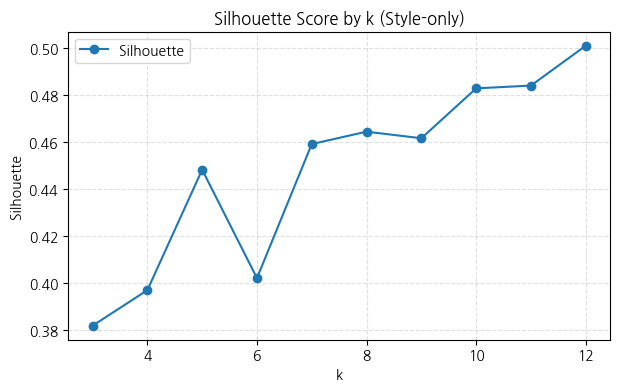

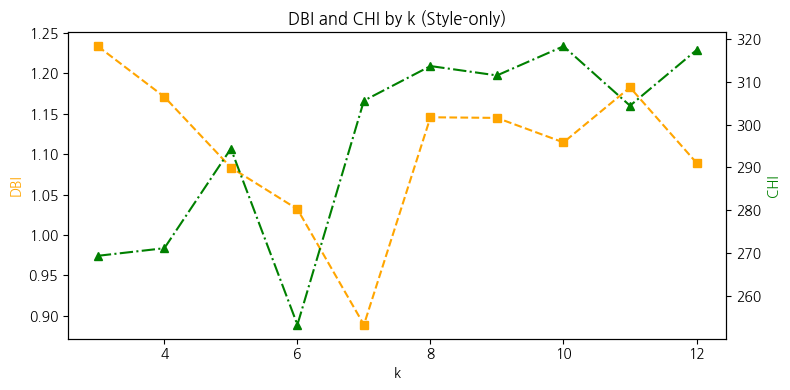

Average silhouette (k=7): 0.459


In [167]:

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, silhouette_samples
from sklearn.decomposition import PCA

STYLE_COLS = ["style_body_last","style_richness_last","style_smoke_last","style_sweetness_last"]

# ==== 1) 스타일 4D만 스케일링 ====
df_ = df.copy()
for c in STYLE_COLS:
    df_[c] = pd.to_numeric(df_[c], errors="coerce")
X = df_[STYLE_COLS].fillna(0.0).to_numpy(float)
sc = StandardScaler().fit(X)
Z  = sc.transform(X)

# ==== 2) k 스캔: 실루엣/DBI/CHI ====
k_range = range(3, 13)   # 필요시 조정
rows = []
for k in k_range:
    km = KMeans(n_clusters=k, n_init="auto", random_state=42)
    lab = km.fit_predict(Z)
    rows.append({
        "k": k,
        "silhouette": silhouette_score(Z, lab),
        "dbi": davies_bouldin_score(Z, lab),
        "chi": calinski_harabasz_score(Z, lab),
        "model": km
    })
metrics = pd.DataFrame(rows)
# 종합 판단: 실루엣(내림) → CHI(내림) → DBI(오름)
ranked = metrics.sort_values(["silhouette","chi","dbi"], ascending=[False,False,True]).reset_index(drop=True)

print("=== k별 지표 (상위부터) ===")
display(ranked[["k","silhouette","dbi","chi"]].round(3))

# ==== 3) k별 비교 시각화 ====
plt.figure(figsize=(7,4))
plt.plot(metrics["k"], metrics["silhouette"], marker="o", label="Silhouette")
plt.title("Silhouette Score by k (Style-only)")
plt.xlabel("k"); plt.ylabel("Silhouette"); plt.grid(True, ls="--", alpha=0.4); plt.legend(); plt.show()

fig, ax1 = plt.subplots(figsize=(8,4))
ax1.plot(metrics["k"], metrics["dbi"], "s--", color="orange", label="DBI (lower better)")
ax1.set_xlabel("k"); ax1.set_ylabel("DBI", color="orange")
ax2 = ax1.twinx()
ax2.plot(metrics["k"], metrics["chi"], "^-.", color="green", label="CHI (higher better)")
ax2.set_ylabel("CHI", color="green")
plt.title("DBI and CHI by k (Style-only)")
fig.tight_layout(); plt.show()


selected_k = 7
best_model = metrics.loc[metrics["k"]==selected_k, "model"].values[0]
labels = best_model.fit_predict(Z)
df_["cluster_taste"] = labels

sil_vals = silhouette_samples(Z, labels)
avg_sil = sil_vals.mean()
print(f"Average silhouette (k={selected_k}): {avg_sil:.3f}")



,k,silhouette,dbi,chi
0,7,0.459153,0.888836,305.552819


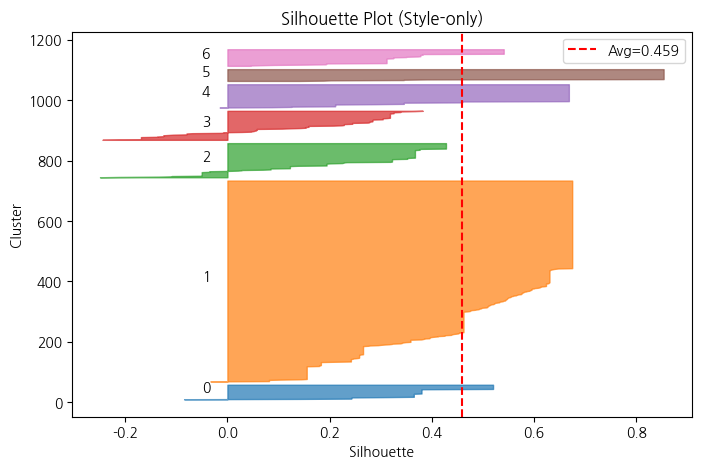

,cluster_taste,count,mean,median,min,max
0,0,49,223.32,128.00,37.50,1000.0
1,1,666,670.74,123.00,9.95,29000.0
2,2,114,373.26,54.12,19.75,24000.0
3,3,97,559.75,57.25,22.75,15000.0
4,4,78,444.80,150.00,39.95,10000.0
5,5,40,185.88,83.60,37.25,2000.0
6,6,56,83.16,53.50,17.95,595.0


,cluster_taste,country,count,ratio(%)
0,0,scotland,37,75.5
1,0,ireland,8,16.3
2,0,usa,3,6.1
3,0,japan,1,2.0
4,1,scotland,514,77.2
5,1,ireland,65,9.8
6,1,japan,56,8.4
7,1,usa,31,4.7
8,2,scotland,61,53.5
9,2,usa,24,21.1


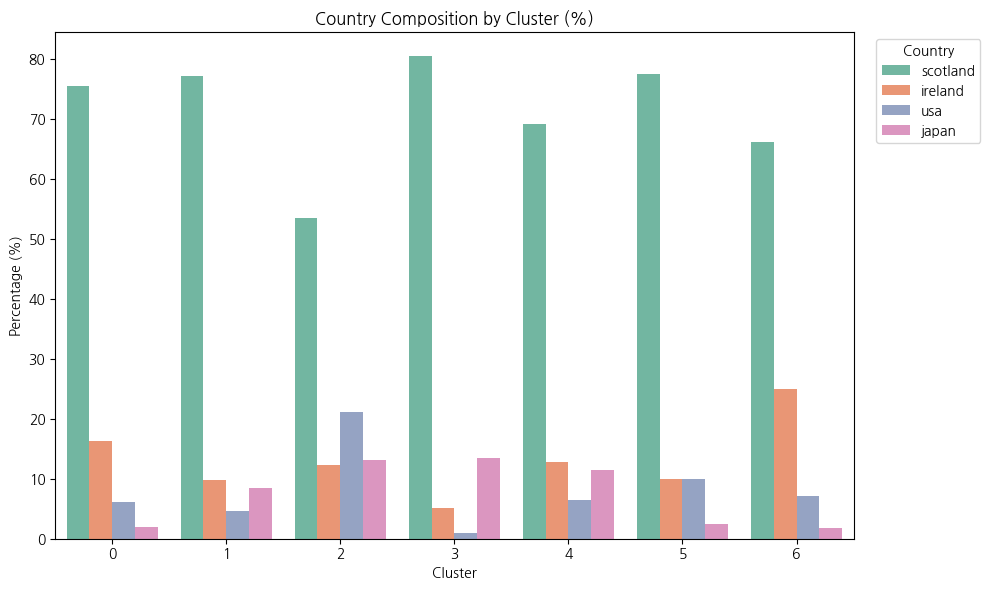

In [168]:
# 1) 준비 + 학습(k=6)
df_prep, X, Z, sc = prepare_style_only(df)
cres6 = _scan_kmeans_style(Z, sc, k_range=[7])
df["cluster_taste"] = cres6.labels

# 2) 이름 붙이기
name_map6 = name_clusters_style_only(cres6.centroids_raw, df)
df["cluster_taste_name"] = df["cluster_taste"].map(name_map6)

# 3) 지표 표 확인
display(cres6.metrics)

# 4) 시각화
plot_silhouette_k6(df, cres6)
plot_pca(df, cres6, cluster_col="cluster_taste")
plot_radar_style(df, cluster_col="cluster_taste")

# 5) 프로파일링 DF & 시각화
price_summary = cluster_price_summary(df); display(price_summary)

country_share = cluster_country_share(df); display(country_share)
plt.figure(figsize=(10,6))
sns.barplot(data=country_share, x="cluster_taste", y="ratio(%)", hue="country", palette="Set2")
plt.title("Country Composition by Cluster (%)"); plt.ylabel("Percentage (%)"); plt.xlabel("Cluster")
plt.legend(title="Country", bbox_to_anchor=(1.02,1), loc="upper left"); plt.tight_layout(); plt.show()

rare_share = cluster_rare_share(df)
if rare_share is not None:
    display(rare_share)
    plt.figure(figsize=(7,4))
    sns.barplot(data=rare_share, x="cluster_taste", y="rare_ratio(%)", palette="flare")
    plt.title("Rare Whisky Share by Cluster (%)"); plt.tight_layout(); plt.show()

In [169]:
df.head()

,name,main_info,whisky_type,volume(cl),alcohol(%),price(£),style_body_last,style_richness_last,style_smoke_last,style_sweetness_last,characters,food_paring,bottler,bottling_decade_clean,bottler_canon,is_independent,bottling_year,age,age_,age_int,is_nas,country,region,casktype,cask_group,colouring,vintage,vintage_clean,nose,palate,finish,reviews,_text_all,price_per_cl,alcohol_density,smoky_family,fruity_family,floral_family,herbal_family,sweet_family,nutty_family,spicy_family,woody_family,earthy_family,malty_family,creamy_family,wine_family,marine_family,other_family,rarity_scarcity,rarity_price_premium,rarity_distillery,rarity_vintage,rarity_score,cluster_taste,cluster_taste_name,pc1,pc2
0,Blended Scotch TB-BSW6 Year Old Thompson Bros,blended scotch whisky,blended,70.0,46.0,34.25,3.0,3.0,0.0,3.0,"Figs, Sultana, Cinnamon, Nutmeg, Toffee, Coffee",NaN,NaN,NaN,thompson bros,1,NaN,NaN,NaN,17.584416,1,scotland,unknown_scotland,not specified,unknown,False,NaN,NaN,"Plum sauce, miso, golden sultanas, cinder toff...","Golden sultanas, raisin loaf, buttered Jamaica...","Soft warm spice; allspice, nutmeg and cinnamon...","Stunning stuff for the money, might well be my...",figs sultana cinnamon nutmeg toffee coffee plu...,0.489286,3220.0,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0.399672,0.000750,0.0,0.000000,0.237533,1,Balanced,-0.019137,-0.615724
1,Johnnie Walker Blue Label,blended scotch whisky,blended,70.0,40.0,158.00,3.0,3.0,1.0,2.0,"Rose, Hazelnut, Honey, Smoke, Dark Chocolate, ...","Octopus, Monkfish, Fondue",NaN,NaN,distillery bottling,0,NaN,NaN,NaN,17.584416,1,scotland,unknown_scotland,not specified,unknown,True,NaN,NaN,"Smooth, silky cereal, syrupy flapjacks, polish...",A silky caress. Unexpectedly strong spicy entr...,A perfectly-integrated slow fade of the palate...,Un elixir. || Excellent Whisky. Smooth on the ...,rose hazelnut honey smoke dark chocolate tobac...,2.257143,2800.0,0,0,1,0,1,1,1,1,1,1,0,0,0,1,0.000000,0.009766,0.0,0.000000,0.005793,1,Balanced,-0.778212,1.594287
2,The Big Ben,blended scotch whisky,blended,50.0,40.0,23.50,3.1,3.0,0.8,3.0,no description,NaN,NaN,NaN,distillery bottling,0,NaN,NaN,NaN,17.584416,1,scotland,unknown_scotland,not specified,unknown,True,NaN,NaN,"Medium weight, malty nose, with hints of orang...","Medium depth, hints of smokiness and sweetness...",Elegant finish.,Very pleased with the whiskey. Highly recommend,no description medium weight malty nose with h...,0.470000,2000.0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0.000000,0.273168,0.0,0.000000,0.162045,1,Balanced,0.081790,0.161437
3,J&B Rare,blended scotch whisky,blended,70.0,40.0,25.25,2.8,2.7,0.2,2.8,no description,NaN,NaN,NaN,distillery bottling,0,NaN,NaN,NaN,17.584416,1,scotland,unknown_scotland,not specified,unknown,True,NaN,NaN,no description,no description,no description,Very nice || Was delighted to find this whisky...,no description no description no description n...,0.360714,2800.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000095,0.0,0.000000,0.000056,1,Balanced,-0.689116,-0.306851
4,Dimple 15 Year OldLitre,blended scotch whisky,blended,100.0,43.0,69.95,3.0,3.0,0.0,3.0,"Caramel, Cinnamon, Vanilla, Dark Chocolate",NaN,NaN,NaN,distillery bottling,0,NaN,15 year old,15.0,15.000000,0,scotland,unknown_scotland,not specified,unknown,Unknown,NaN,NaN,no description,no description,no description,NaN,caramel cinnamon vanilla dark chocolate no des...,0.699500,4300.0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0.333333,0.003351,0.0,0.312207,0.323193,1,Balanced,-0.019137,-0.615724


In [170]:
df['cluster_taste'].unique()

array([1, 3, 0, 2, 6, 4, 5], dtype=int32)

In [171]:
df['cluster_taste_name'].value_counts()

,count
cluster_taste_name,
Balanced,780
Smoky & Full-Body,97
Rich & Full-Body,78
Sweet,56
Sweet & Rich & Full-Body,49
Full-Body,40


In [172]:

cols_to_include = [
    "price(£)", "rarity_score", "age_", "vintage_clean"
]
exist_cols = [c for c in cols_to_include if c in df.columns]  # 실제 존재하는 컬럼만 선택

# 1️⃣ 그룹 요약
cluster_summary = (
    df.groupby("cluster_taste")
      .agg({**{c:"mean" for c in exist_cols}, **{"name":"count"}})
      .rename(columns={"name":"count"})
      .round(2)
      .reset_index()
)

# 2️⃣ 클러스터 이름 매핑
if "cluster_taste_name" in df.columns:
    cluster_summary["cluster_name"] = df.groupby("cluster_taste")["cluster_taste_name"].first().values
else:
    cluster_summary["cluster_name"] = [f"Cluster {i}" for i in cluster_summary["cluster_taste"]]

# 3️⃣ 보기 좋게 정렬
cluster_summary = cluster_summary[
    ["cluster_taste", "cluster_name", "count"] + [c for c in exist_cols if c in df.columns]
]

# 4️⃣ 정렬 (평균 가격 순으로)
cluster_summary = cluster_summary.sort_values("price(£)", ascending=False).reset_index(drop=True)

display(cluster_summary)

,cluster_taste,cluster_name,count,price(£),rarity_score,age_,vintage_clean
0,1,Balanced,666,670.74,0.35,15.69,1972.33
1,3,Smoky & Full-Body,97,559.75,0.26,14.09,NaN
2,4,Rich & Full-Body,78,444.80,0.45,20.21,NaN
3,2,Balanced,114,373.26,0.18,15.16,2017.00
4,0,Sweet & Rich & Full-Body,49,223.32,0.44,21.35,NaN
5,5,Full-Body,40,185.88,0.46,16.64,2007.00
6,6,Sweet,56,83.16,0.22,14.44,NaN


In [173]:
# === 클러스터별 종합 요약표 ===

style_cols = ["style_body_last","style_richness_last","style_smoke_last","style_sweetness_last"]
other_cols = ["price(£)", "rarity_score", "age_", "vintage_clean"]

exist_cols = [c for c in style_cols + other_cols if c in df.columns]

# 그룹 집계
cluster_summary_full = (
    df.groupby("cluster_taste")
      .agg({c:"mean" for c in exist_cols} | {"name":"count"})
      .rename(columns={"name":"count"})
      .round(2)
      .reset_index()
)

# 이름 붙이기
if "cluster_taste_name" in df.columns:
    cluster_summary_full["cluster_name"] = df.groupby("cluster_taste")["cluster_taste_name"].first().values
else:
    cluster_summary_full["cluster_name"] = [f"Cluster {i}" for i in cluster_summary_full["cluster_taste"]]

# 보기 좋은 순서
cols_order = (
    ["cluster_taste","cluster_name","count"]
    + [c for c in style_cols if c in df.columns]
    + [c for c in other_cols if c in df.columns]
)
cluster_summary_full = cluster_summary_full[cols_order]

# 가격 기준 정렬
cluster_summary_full = cluster_summary_full.sort_values("price(£)", ascending=False).reset_index(drop=True)

display(cluster_summary_full)

,cluster_taste,cluster_name,count,style_body_last,style_richness_last,style_smoke_last,style_sweetness_last,price(£),rarity_score,age_,vintage_clean
0,1,Balanced,666,3.03,2.99,0.55,2.95,670.74,0.35,15.69,1972.33
1,3,Smoky & Full-Body,97,3.24,2.95,2.78,2.60,559.75,0.26,14.09,NaN
2,4,Rich & Full-Body,78,4.02,4.06,0.26,2.97,444.80,0.45,20.21,NaN
3,2,Balanced,114,2.09,1.87,0.17,2.65,373.26,0.18,15.16,2017.00
4,0,Sweet & Rich & Full-Body,49,3.74,3.77,0.08,3.99,223.32,0.44,21.35,NaN
5,5,Full-Body,40,3.99,2.96,0.08,2.95,185.88,0.46,16.64,2007.00
6,6,Sweet,56,2.79,2.38,0.12,4.02,83.16,0.22,14.44,NaN


In [174]:
import plotly.graph_objects as go

radar_df = (cluster_summary_full
            .sort_values("cluster_taste")
            .assign(label=lambda d: d["cluster_taste"].astype(str) + " · " + d["cluster_name"]))

for _, row in radar_df.iterrows():
    fig = go.Figure()
    fig.add_trace(go.Scatterpolar(
        r=row[style_cols].values,
        theta=style_cols,
        fill='toself',
        name=row["label"],
        line=dict(width=3)
    ))
    fig.update_layout(
        title=f"Cluster {row['label']} — Flavor Profile (0–5)",
        template="plotly_white",
        polar=dict(radialaxis=dict(visible=True, range=[0,5], tickvals=[0,1,2,3,4,5])),
        showlegend=False
    )
    fig.show()

In [175]:
import plotly.graph_objects as go
import pandas as pd

# 준비: style 평균이 들어있는 요약 df (앞서 만든 cluster_summary_full 사용)
style_cols = ["style_body_last","style_richness_last","style_smoke_last","style_sweetness_last"]

# 번호 오름차순 정렬 + 범례 라벨 생성 "번호 · 이름"
radar_df = (cluster_summary_full
            .sort_values("cluster_taste")
            .assign(label=lambda d: d["cluster_taste"].astype(str) + " · " + d["cluster_name"]))

# 7개가 많으니 반반 나눠서 두 장으로
split_idx = len(radar_df)//2 + len(radar_df)%2  # 앞쪽이 하나 더 많게
group1, group2 = radar_df.iloc[:split_idx], radar_df.iloc[split_idx:]

def make_radar(group, title):
    fig = go.Figure()
    for _, row in group.iterrows():
        fig.add_trace(go.Scatterpolar(
            r=row[style_cols].values,
            theta=style_cols,
            fill='toself',
            name=row["label"],             # ← 범례에 "번호 · 이름"
            line=dict(width=2),
            opacity=0.45
        ))
    fig.update_layout(
        title=title,
        template="plotly_white",
        polar=dict(radialaxis=dict(visible=True, range=[0,5], tickvals=[0,1,2,3,4,5])),
        legend=dict(title="Cluster (번호 · 이름)", orientation="v", x=1.02, y=1)
    )
    return fig

fig1 = make_radar(group1, "Flavor Profile by Cluster (Part 1)")
fig2 = make_radar(group2, "Flavor Profile by Cluster (Part 2)")
fig1.show(); fig2.show()

In [176]:
# Pandas Styler (노트북/HTML 보고서에 적합)
def style_table(df):
    cols_order = ["cluster_taste","cluster_name","count"] + style_cols + metric_cols
    cols_order = [c for c in cols_order if c in df.columns]
    st = (df[cols_order]
          .sort_values("cluster_taste")
          .style
          .format({c:"{:.2f}" for c in style_cols+metric_cols if c in df.columns})
          .bar(subset=["count"], color="#b3d1ff")
          .background_gradient(subset=style_cols, cmap="Greens")
          .background_gradient(subset=[c for c in metric_cols if c in df.columns], cmap="Oranges")
          .set_properties(**{"text-align":"center"})
          .set_table_styles([{"selector":"th","props":[("text-align","center")]}])
         )
    return st

style_table(cluster_summary_full)

,cluster_taste,cluster_name,count,style_body_last,style_richness_last,style_smoke_last,style_sweetness_last,price(£),rarity_score,age_
4,0,Sweet & Rich & Full-Body,49,3.74,3.77,0.08,3.99,223.32,0.44,21.35
0,1,Balanced,666,3.03,2.99,0.55,2.95,670.74,0.35,15.69
3,2,Balanced,114,2.09,1.87,0.17,2.65,373.26,0.18,15.16
1,3,Smoky & Full-Body,97,3.24,2.95,2.78,2.60,559.75,0.26,14.09
2,4,Rich & Full-Body,78,4.02,4.06,0.26,2.97,444.80,0.45,20.21
5,5,Full-Body,40,3.99,2.96,0.08,2.95,185.88,0.46,16.64
6,6,Sweet,56,2.79,2.38,0.12,4.02,83.16,0.22,14.44


In [177]:
import pandas as pd
import numpy as np

# 1) 복사 + 표시용 전처리
tbl = cluster_summary_full.copy()

# 표시용 결측 기호
tbl["vintage_clean"] = tbl["vintage_clean"].fillna("—")

style_cols  = ["style_body_last","style_richness_last","style_smoke_last","style_sweetness_last"]
metric_cols = ["price(£)","rarity_score","age_"]
num_cols = [c for c in style_cols + metric_cols if c in tbl.columns]  # 숫자만!

# 2) 숫자 컬럼은 확실히 숫자로
tbl[num_cols] = tbl[num_cols].apply(pd.to_numeric, errors="coerce")

# 3) Styler: 숫자 컬럼만 포맷 적용
fmt_map = {c: "{:,.2f}" for c in num_cols}

sty = (
    tbl.style
      .format(fmt_map)  # ★ 숫자 컬럼만
      .background_gradient(cmap="Greens", subset=[c for c in style_cols if c in tbl.columns])
      .background_gradient(cmap="Oranges", subset=[c for c in metric_cols if c in tbl.columns])
      .set_properties(**{"text-align":"center"})
      .set_table_styles([{"selector":"th","props":[("text-align","center")]}])
)

# 4) HTML 저장
html_path = "cluster_summary_table.html"
with open(html_path, "w", encoding="utf-8") as f:
    f.write(sty.to_html())

print(f"✅ 저장 완료: {html_path}")

✅ 저장 완료: cluster_summary_table.html


# 클러스터링 프로파일링

In [180]:
import plotly.express as px
import pandas as pd

# 데이터 복사
df_country = df.copy()
df_country["country"] = df_country["country"].fillna("Unknown")
df_country["cluster_label"] = (
    df_country["cluster_taste"].astype(str) + " · " + df_country["cluster_taste_name"]
)

# 클러스터별 국가 비율 계산
country_share = (
    df_country.groupby(["cluster_label", "country"])
    .size()
    .reset_index(name="count")
)
country_share["ratio(%)"] = (
    100 * country_share["count"] / country_share.groupby("cluster_label")["count"].transform("sum")
).round(1)

# 막대그래프 (비율 기준)
fig_country = px.bar(
    country_share,
    x="cluster_label",
    y="ratio(%)",
    color="country",
    text="ratio(%)",
    title="Country Composition by Cluster (%)",
    color_discrete_sequence=px.colors.qualitative.Set2,
)
fig_country.update_traces(textposition="outside")
fig_country.update_layout(
    xaxis_title="Cluster (번호 · 이름)",
    yaxis_title="Country Ratio (%)",
    legend_title="Country",
    plot_bgcolor="white",
    bargap=0.15,
    font=dict(size=11),
)
fig_country.show()

In [185]:
df.to_csv('/content/drive/MyDrive/week_hands_on_project5/whiskey/whisky_clustered.csv',index=False)